# 不動産価格予測モデル検討レポート

## 1. はじめに

本レポートでは、米国の特定地域の不動産売買データを用いて、不動産価格予測モデルを構築・評価する。  
本分析は、将来の同様データに対する価格予測サービスの有用性を評価し、事業化の可否や改善策を検討するための基礎資料となる。  

## 2. データ概要

対象データには以下の変数が含まれる。

- **date**: 売買成立日
- **price**: 売買価格(予測対象)
- **sqft_lot**: 敷地面積
- **sqft_living**: 居住スペース面積
- **grade**: 建築・デザイン品質評価(1～13)
- **lat**: 緯度
- **long**: 経度
- **yr_built**: 建築年
- **yr_renovated**: 最終リノベーション年(0は未リノベーション)

本分析では、`date` と `yr_renovated` をモデル利用可能な特徴量へ変換する。

## 3. 分析環境とパッケージ


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%matplotlib inline
sns.set_style("whitegrid")
pd.options.display.float_format = '{:,.2f}'.format


## 4. データ読み込みと基本確認

`data.csv` を読み込み、`date` を日付型へ変換する。


In [2]:
# データ読み込み
data = pd.read_csv("data.csv", dtype={'date': str})
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')

# 初期データ確認
display(data.head())
display(data.info())


,date,price,sqft_lot,sqft_living,grade,lat,long,yr_built,yr_renovated
0,2014-10-13,221900,5650,1180,7,47.51,-122.26,1955,0
1,2014-12-09,538000,7242,2570,7,47.72,-122.32,1951,1991
2,2015-02-25,180000,10000,770,6,47.74,-122.23,1933,0
3,2014-12-09,604000,5000,1960,7,47.52,-122.39,1965,0
4,2015-02-18,510000,8080,1680,8,47.62,-122.05,1987,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          21613 non-null  datetime64[ns]
 1   price         21613 non-null  int64         
 2   sqft_lot      21613 non-null  int64         
 3   sqft_living   21613 non-null  int64         
 4   grade         21613 non-null  int64         
 5   lat           21613 non-null  float64       
 6   long          21613 non-null  float64       
 7   yr_built      21613 non-null  int64         
 8   yr_renovated  21613 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 1.5 MB


None

## 5. 特徴量エンジニアリング

ここで、`date` からの特徴量抽出と `yr_renovated` からの特徴量変換を行う。

- `date` を用いて `year_sold`, `month_sold`, `days_since_2014_01_01` を作成する
- `yr_renovated` を用いて、リノベーション有無フラグ(`renovated_flag`)およびリノベから売却までの経過年数(`years_since_renovation`)を作成する。

その後、統計量を再確認する。

In [3]:
base_date = pd.Timestamp("2014-01-01")
data['year_sold'] = data['date'].dt.year
data['month_sold'] = data['date'].dt.month
data['days_since_2014_01_01'] = (data['date'] - base_date).dt.days + 1

data['renovated_flag'] = (data['yr_renovated'] > 0).astype(int)
data['years_since_renovation'] = np.where(
    data['yr_renovated'] > 0,
    data['year_sold'] - data['yr_renovated'],
    0
)

# モデル用数値カラム
numeric_cols = [
    'price','sqft_lot','sqft_living','grade','lat','long','yr_built',
    'year_sold','month_sold','days_since_2014_01_01','renovated_flag','years_since_renovation'
]

describe_df = data[numeric_cols].describe()

# 表の表記を日本語に変更
describe_df = describe_df.rename(index={
    'count': '件数',
    'mean': '平均',
    'std': '標準偏差',
    'min': '最小',
    '25%': '25%',
    '50%': '中央値',
    '75%': '75%',
    'max': '最大'
})

# カラム名を日本語に変更
describe_df = describe_df.rename(columns={
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'year_sold': '売却年',
    'month_sold': '売却月',
    'days_since_2014_01_01': '2014年1月1日からの日数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数'
})

describe_df = describe_df.applymap(lambda x: f"{x:,.2f}")
display(describe_df)


C:\Users\rainb\AppData\Local\Temp\ipykernel_12208\1450717754.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  describe_df = describe_df.applymap(lambda x: f"{x:,.2f}")


,価格,敷地面積,居住スペース面積,建築・デザイン品質評価,緯度,経度,建築年,売却年,売却月,2014年1月1日からの日数,リノベーションフラグ,リノベーションからの経過年数
件数,"21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00"
平均,"540,088.14","15,106.97","2,079.90",7.66,47.56,-122.21,"1,971.01","2,014.32",6.57,302.19,0.04,0.78
標準偏差,"367,127.20","41,420.51",918.44,1.18,0.14,0.14,29.37,0.47,3.12,113.05,0.20,4.90
最小,"75,000.00",520.00,290.00,1.00,47.16,-122.52,"1,900.00","2,014.00",1.00,122.00,0.00,-1.00
25%,"321,950.00","5,040.00","1,427.00",7.00,47.47,-122.33,"1,951.00","2,014.00",4.00,203.00,0.00,0.00
中央値,"450,000.00","7,618.00","1,910.00",7.00,47.57,-122.23,"1,975.00","2,014.00",6.00,289.00,0.00,0.00
75%,"645,000.00","10,688.00","2,550.00",8.00,47.68,-122.12,"1,997.00","2,015.00",9.00,413.00,0.00,0.00
最大,"7,700,000.00","1,651,359.00","13,540.00",13.00,47.78,-121.31,"2,015.00","2,015.00",12.00,512.00,1.00,80.00


## 5.2 エラーデータの除外とデータ再確認

リノベーションからの経過年数(`years_since_renovation`)が負の値となっているデータは、`yr_renovated` が `year_sold` より後になっているためエラーデータと判断し、除外します。エラーデータを除外した後、再度統計量を表で確認します。


In [4]:
# エラーデータの除外
initial_count = data.shape[0]
data = data[data['years_since_renovation'] >= 0]
filtered_count = data.shape[0]
removed_count = initial_count - filtered_count

print(f"除外前のデータ件数: {initial_count}")
print(f"除外後のデータ件数: {filtered_count}")
print(f"除外したエラーデータの件数: {removed_count}")

# 再度統計量を確認
describe_df = data[numeric_cols].describe()

# 表の表記を日本語に変更
describe_df = describe_df.rename(index={
    'count': '件数',
    'mean': '平均',
    'std': '標準偏差',
    'min': '最小',
    '25%': '25%',
    '50%': '中央値',
    '75%': '75%',
    'max': '最大'
})

# カラム名を日本語に変更
describe_df = describe_df.rename(columns={
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'year_sold': '売却年',
    'month_sold': '売却月',
    'days_since_2014_01_01': '2014年1月1日からの日数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数'
})

describe_df = describe_df.applymap(lambda x: f"{x:,.2f}")
display(describe_df)


除外前のデータ件数: 21613
除外後のデータ件数: 21607
除外したエラーデータの件数: 6


C:\Users\rainb\AppData\Local\Temp\ipykernel_12208\847938704.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  describe_df = describe_df.applymap(lambda x: f"{x:,.2f}")


,価格,敷地面積,居住スペース面積,建築・デザイン品質評価,緯度,経度,建築年,売却年,売却月,2014年1月1日からの日数,リノベーションフラグ,リノベーションからの経過年数
件数,"21,607.00","21,607.00","21,607.00","21,607.00","21,607.00","21,607.00","21,607.00","21,607.00","21,607.00","21,607.00","21,607.00","21,607.00"
平均,"540,061.05","15,107.16","2,079.59",7.66,47.56,-122.21,"1,971.01","2,014.32",6.57,302.22,0.04,0.78
標準偏差,"367,158.09","41,425.79",918.31,1.18,0.14,0.14,29.37,0.47,3.12,113.05,0.20,4.90
最小,"75,000.00",520.00,290.00,1.00,47.16,-122.52,"1,900.00","2,014.00",1.00,122.00,0.00,0.00
25%,"321,725.00","5,040.00","1,423.50",7.00,47.47,-122.33,"1,951.00","2,014.00",4.00,203.00,0.00,0.00
中央値,"450,000.00","7,618.00","1,910.00",7.00,47.57,-122.23,"1,975.00","2,014.00",6.00,289.00,0.00,0.00
75%,"645,000.00","10,687.50","2,550.00",8.00,47.68,-122.12,"1,997.00","2,015.00",9.00,413.00,0.00,0.00
最大,"7,700,000.00","1,651,359.00","13,540.00",13.00,47.78,-121.31,"2,015.00","2,015.00",12.00,512.00,1.00,80.00


## 5.3 追加のデータクリーニングと異常値の処理

前回のデータ再確認において、`years_since_renovation` や `sqft_lot` に異常値や極端な値が存在することが判明しました。これらの異常値はモデルの性能に悪影響を及ぼす可能性があるため、次のステップとしてさらなるデータクリーニングを実施します。

### 1. 敷地面積 (`sqft_lot`) の異常値の検出と処理

**問題点**:
- 最大値が **1,651,359.00** 平方フィートとなっており、現実的な範囲を大きく超えています。

**対応策**:
- 敷地面積の上限を設定し、それを超えるデータを除外または修正します。
- また、分布を視覚化して他の異常値も確認します。

In [5]:
# 敷地面積が大きい上位10個のデータを抽出
top10_sqft_lot = data.sort_values(by='sqft_lot', ascending=False).head(10)
display(top10_sqft_lot)

,date,price,sqft_lot,sqft_living,grade,lat,long,yr_built,yr_renovated,year_sold,month_sold,days_since_2014_01_01,renovated_flag,years_since_renovation
1719,2015-03-27,700000,1651359,1300,6,47.23,-122.02,1920,0,2015,3,451,0,0
17319,2015-05-04,190000,1164794,710,5,47.69,-121.91,1915,0,2015,5,489,0,0
7647,2014-05-21,542500,1074218,3010,8,47.46,-122.00,1931,0,2014,5,141,0,0
7769,2015-01-19,855000,1024068,4030,10,47.46,-121.74,2006,0,2015,1,384,0,0
3949,2014-09-05,998000,982998,3770,10,47.41,-122.09,1992,0,2014,9,248,0,0
4441,2014-07-30,790000,982278,2560,8,47.70,-121.86,2004,0,2014,7,211,0,0
6691,2015-03-20,1998000,920423,3900,12,47.54,-121.76,2009,0,2015,3,444,0,0
7077,2015-01-05,1650000,881654,3920,11,47.54,-121.90,2002,0,2015,1,370,0,0
20452,2015-04-15,1600000,871200,6530,11,47.66,-121.88,2008,0,2015,4,470,0,0
9714,2015-01-07,937500,871200,5545,11,47.68,-121.88,2003,0,2015,1,372,0,0


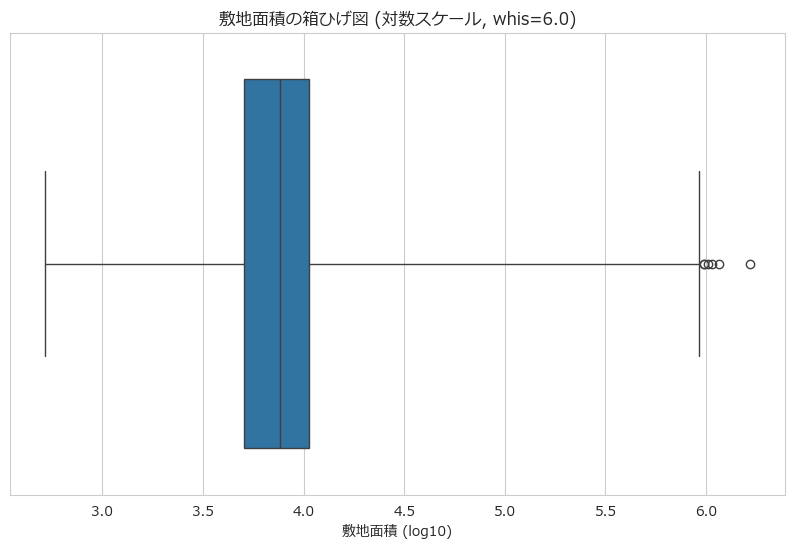

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語フォントの設定
plt.rcParams['font.family'] = 'meiryo'

# カスタムwhisの設定
custom_whis = 6.0  # 例として2.0に設定

# 敷地面積の対数変換
log_sqft_lot = np.log10(data['sqft_lot'])

# 箱ひげ図の作成（カスタムwhisを使用）
plt.figure(figsize=(10, 6))
sns.boxplot(x=log_sqft_lot, whis=custom_whis)
plt.title(f"敷地面積の箱ひげ図 (対数スケール, whis={custom_whis})")
plt.xlabel("敷地面積 (log10)")
plt.show()

箱ひげ図の上限（対数スケール）: 5.99
箱ひげ図の上限（元のスケール）: 971,739.09 平方フィート
敷地面積の上限: 971,739.09 平方フィート
除外前のデータ件数: 21607
除外後のデータ件数: 21601
除外したデータの件数: 6


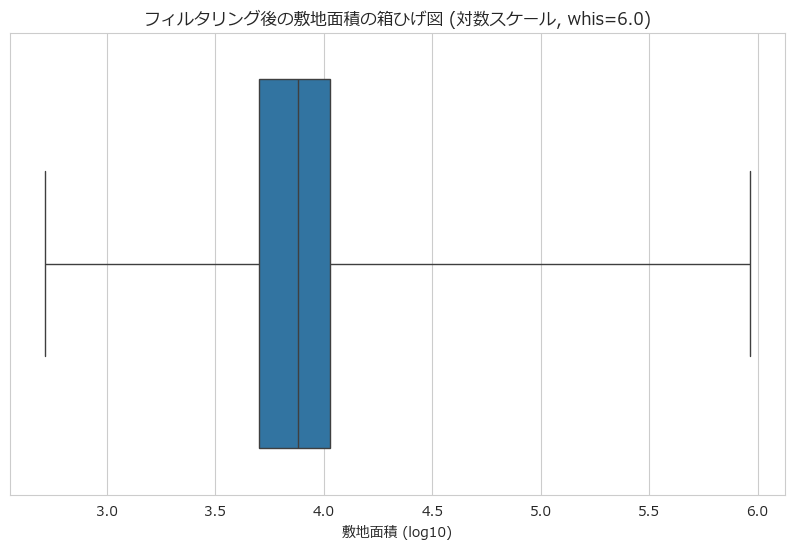

In [9]:
# 箱ひげ図の統計量を計算
Q1 = log_sqft_lot.quantile(0.25)
Q3 = log_sqft_lot.quantile(0.75)
IQR = Q3 - Q1
upper_whisker = Q3 + custom_whis * IQR
lower_whisker = Q1 - custom_whis * IQR

# 元のスケールに戻すために対数を逆変換
upper_whisker_original = 10 ** upper_whisker
lower_whisker_original = 10 ** lower_whisker

print(f"箱ひげ図の上限（対数スケール）: {upper_whisker:.2f}")
print(f"箱ひげ図の上限（元のスケール）: {upper_whisker_original:,.2f} 平方フィート")

# 敷地面積の上限を設定
upper_limit_sqft_lot = upper_whisker_original

# 敷地面積の上限を用いてデータをフィルタリング
initial_count = data.shape[0]
data_filtered = data[data['sqft_lot'] <= upper_limit_sqft_lot]
filtered_count = data_filtered.shape[0]
removed_count = initial_count - filtered_count

print(f"敷地面積の上限: {upper_limit_sqft_lot:,.2f} 平方フィート")
print(f"除外前のデータ件数: {initial_count}")
print(f"除外後のデータ件数: {filtered_count}")
print(f"除外したデータの件数: {removed_count}")

# フィルタリング後の箱ひげ図を再プロット（確認用）
log_sqft_lot_filtered = np.log10(data_filtered['sqft_lot'])

plt.figure(figsize=(10, 6))
sns.boxplot(x=log_sqft_lot_filtered, whis=custom_whis)
plt.title(f"フィルタリング後の敷地面積の箱ひげ図 (対数スケール, whis={custom_whis})")
plt.xlabel("敷地面積 (log10)")
plt.show()

2. 建築年 (yr_built) の異常値の検出と処理
問題点:

最小値が 1,900 年となっており、非常に古い物件が含まれています。これらの物件は市場特性が異なる可能性があります。
対応策:

建築年の範囲を現実的な範囲に設定し、それを超えるデータを除外します。
例えば、建築年を 1800年 から 2024年 の間に制限します。

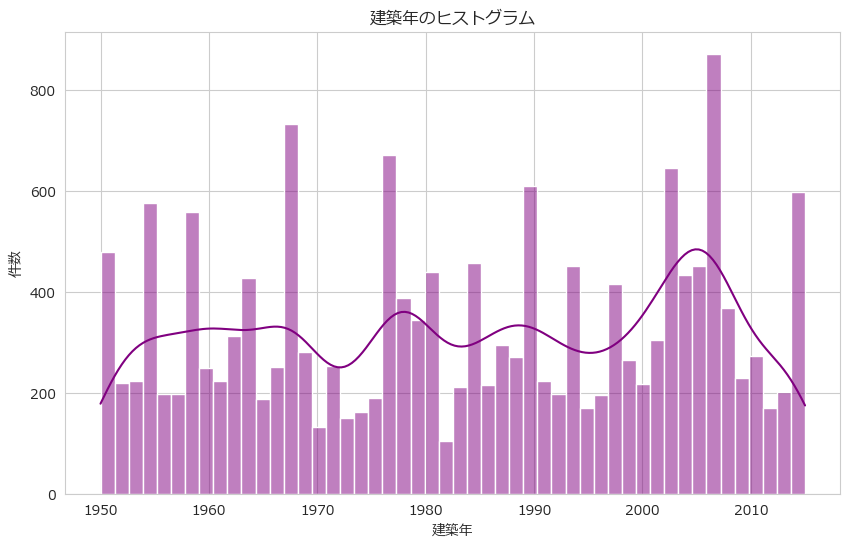

建築年の異常値除外前のデータ件数: 16674
建築年の異常値除外後のデータ件数: 16674
除外した建築年の異常値の件数: 0


In [12]:
# 建築年の分布を確認
plt.figure(figsize=(10, 6))
sns.histplot(data['yr_built'], bins=50, kde=True, color='purple')
plt.title("建築年のヒストグラム")
plt.xlabel("建築年")
plt.ylabel("件数")
plt.show()

# 建築年の範囲を設定
lower_bound_yr_built = 1950
upper_bound_yr_built = 2024
initial_count = data.shape[0]
data = data[(data['yr_built'] >= lower_bound_yr_built) & (data['yr_built'] <= upper_bound_yr_built)]
filtered_count = data.shape[0]
removed_count = initial_count - filtered_count

print(f"建築年の異常値除外前のデータ件数: {initial_count}")
print(f"建築年の異常値除外後のデータ件数: {filtered_count}")
print(f"除外した建築年の異常値の件数: {removed_count}")


## 5.3 カスタム `whis` による箱ひげ図の表示

このセクションでは、指定した各列に対してカスタム `whis` パラメータを用いた箱ひげ図を表示し、上限値を計算します。計算された上限値は後続のデータフィルタリングで使用します。

### スクリプト1: 箱ひげ図の表示と上限値の計算


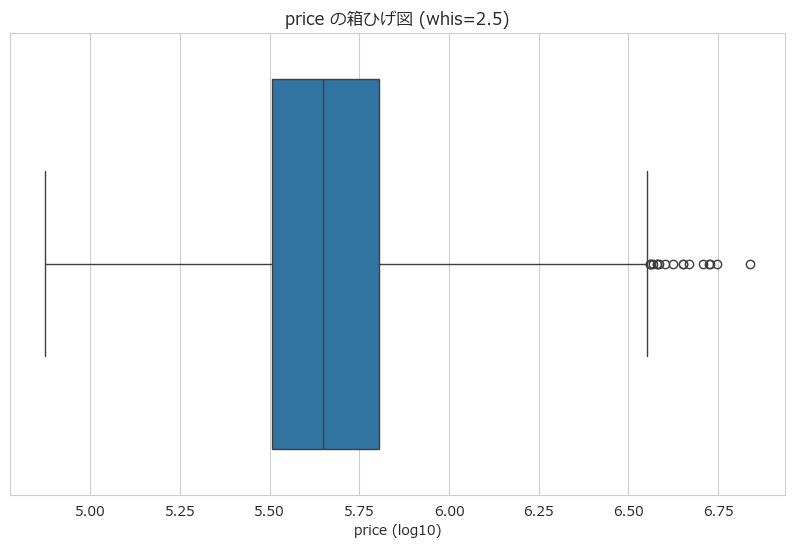

--- price の上限値 ---
箱ひげ図の上限（対数スケール）: 6.55
箱ひげ図の上限（元のスケール）: 3,578,305.91 平方フィート




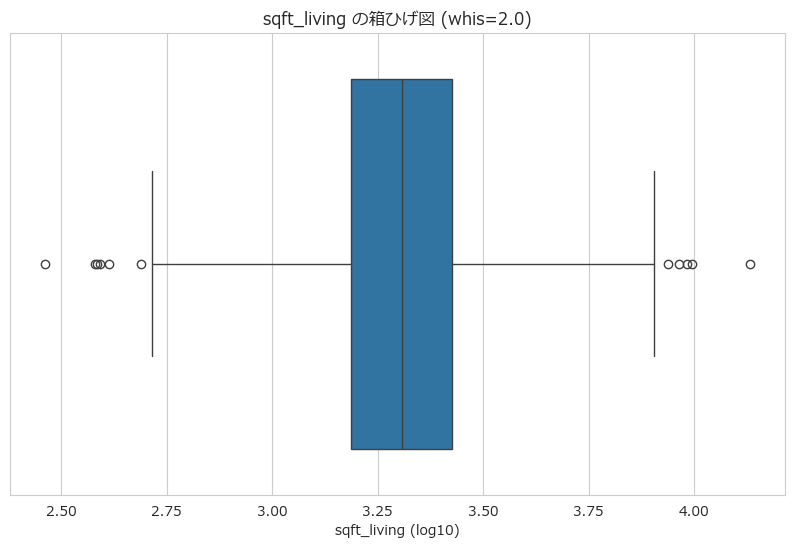

--- sqft_living の上限値 ---
箱ひげ図の上限（対数スケール）: 3.90
箱ひげ図の上限（元のスケール）: 8,025.87 平方フィート


計算された上限値:
price: 3,578,305.91
sqft_living: 8,025.87


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語フォントの設定
plt.rcParams['font.family'] = 'meiryo'

# 上限値を保存する辞書を初期化
upper_limits = {}

def plot_boxplot_custom_whis(df, column, custom_whis=1.5, log_transform=False):
    """
    指定した列の箱ひげ図をカスタムwhisでプロットし、上限値を計算して保存する関数。
    
    Parameters:
    - df: pandas DataFrame
    - column: str, 処理対象の列名
    - custom_whis: float, IQRに乗じる係数
    - log_transform: bool, 対数変換を行うかどうか
    """
    if log_transform:
        # 対数変換
        data = np.log10(df[column])
        xlabel = f"{column} (log10)"
    else:
        data = df[column]
        xlabel = column
    
    # 箱ひげ図の作成
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data, whis=custom_whis)
    plt.title(f"{column} の箱ひげ図 (whis={custom_whis})")
    plt.xlabel(xlabel)
    plt.show()
    
    # 四分位数とIQRの計算
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    upper_whisker = Q3 + custom_whis * IQR
    
    if log_transform:
        # 元のスケールに戻す
        upper_limit = 10 ** upper_whisker
    else:
        upper_limit = upper_whisker
    
    # 上限値を辞書に保存
    upper_limits[column] = upper_limit
    
    print(f"--- {column} の上限値 ---")
    if log_transform:
        print(f"箱ひげ図の上限（対数スケール）: {upper_whisker:.2f}")
        print(f"箱ひげ図の上限（元のスケール）: {upper_limit:,.2f} 平方フィート")
    else:
        print(f"{column} の上限: {upper_limit:,.2f}")
    print("\n")

# 処理対象の列と設定（各列ごとに異なるwhisを設定）
columns_to_plot = [
    #{'column': 'sqft_lot', 'custom_whis': 6.0, 'log_transform': True},
    {'column': 'price', 'custom_whis': 2.5, 'log_transform': True},
    {'column': 'sqft_living', 'custom_whis': 2.0, 'log_transform': True},
    # 必要に応じて他の列も追加
]

# 箱ひげ図のプロットと上限値の計算
for col in columns_to_plot:
    plot_boxplot_custom_whis(
        df=data,
        column=col['column'],
        custom_whis=col['custom_whis'],
        log_transform=col['log_transform']
    )

# 上限値の確認
print("計算された上限値:")
for column, limit in upper_limits.items():
    print(f"{column}: {limit:,.2f}")


## 5.4 カスタム `whis` によるデータのフィルタリング

前セクションで計算された各列の上限値を用いて、データフレームから異常値を除外します。このセクションでは、各列ごとに異なる `whis` パラメータに基づいた上限値を使用してデータをフィルタリングします。

### スクリプト2: データのフィルタリング


In [18]:
# フィルタリング用の関数を定義
def filter_data_custom_whis(df, upper_limits):
    """
    指定した上限値に基づいてデータフレームをフィルタリングする関数。
    
    Parameters:
    - df: pandas DataFrame
    - upper_limits: dict, 各列の上限値
    
    Returns:
    - フィルタリング後のDataFrame
    """
    initial_count = df.shape[0]
    for column, upper_limit in upper_limits.items():
        df = df[df[column] <= upper_limit]
        print(f"{column} の上限 {upper_limit:,.2f} を用いてフィルタリング完了")
    
    filtered_count = df.shape[0]
    removed_count = initial_count - filtered_count
    
    print(f"\nフィルタリング前のデータ件数: {initial_count}")
    print(f"フィルタリング後のデータ件数: {filtered_count}")
    print(f"除外したデータの件数: {removed_count}")
    
    return df

# 上限値に基づいてデータをフィルタリング
data_filtered = filter_data_custom_whis(df=data, upper_limits=upper_limits)

# フィルタリング後のデータ確認
display(data_filtered.head())
display(data_filtered.info())


price の上限 3,578,305.91 を用いてフィルタリング完了
sqft_living の上限 8,025.87 を用いてフィルタリング完了

フィルタリング前のデータ件数: 16674
フィルタリング後のデータ件数: 16655
除外したデータの件数: 19


,date,price,sqft_lot,sqft_living,grade,lat,long,yr_built,yr_renovated,year_sold,month_sold,days_since_2014_01_01,renovated_flag,years_since_renovation
0,2014-10-13,221900,5650,1180,7,47.51,-122.26,1955,0,2014,10,286,0,0
1,2014-12-09,538000,7242,2570,7,47.72,-122.32,1951,1991,2014,12,343,1,23
3,2014-12-09,604000,5000,1960,7,47.52,-122.39,1965,0,2014,12,343,0,0
4,2015-02-18,510000,8080,1680,8,47.62,-122.05,1987,0,2015,2,414,0,0
5,2014-05-12,1225000,101930,5420,11,47.66,-122.00,2001,0,2014,5,132,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 16655 entries, 0 to 21612
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    16655 non-null  datetime64[ns]
 1   price                   16655 non-null  int64         
 2   sqft_lot                16655 non-null  int64         
 3   sqft_living             16655 non-null  int64         
 4   grade                   16655 non-null  int64         
 5   lat                     16655 non-null  float64       
 6   long                    16655 non-null  float64       
 7   yr_built                16655 non-null  int64         
 8   yr_renovated            16655 non-null  int64         
 9   year_sold               16655 non-null  int32         
 10  month_sold              16655 non-null  int32         
 11  days_since_2014_01_01   16655 non-null  int64         
 12  renovated_flag          16655 non-null  int32      

None

## 5.5 フィルタリング後のデータの再確認

フィルタリング後のデータに対して再度統計量を確認し、データの品質が向上していることを確認します。

### スクリプト3: フィルタリング後の統計量確認


In [19]:
# フィルタリング後の統計量を確認
numeric_cols_filtered = [
    'price','sqft_lot','sqft_living','grade','lat','long','yr_built',
    'year_sold','month_sold','days_since_2014_01_01','renovated_flag','years_since_renovation'
]

describe_df_filtered = data_filtered[numeric_cols_filtered].describe()

# 表の表記を日本語に変更
describe_df_filtered = describe_df_filtered.rename(index={
    'count': '件数',
    'mean': '平均',
    'std': '標準偏差',
    'min': '最小',
    '25%': '25%',
    '50%': '中央値',
    '75%': '75%',
    'max': '最大'
})

# カラム名を日本語に変更
describe_df_filtered = describe_df_filtered.rename(columns={
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'year_sold': '売却年',
    'month_sold': '売却月',
    'days_since_2014_01_01': '2014年1月1日からの日数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数'
})

describe_df_filtered = describe_df_filtered.applymap(lambda x: f"{x:,.2f}")
display(describe_df_filtered)


C:\Users\rainb\AppData\Local\Temp\ipykernel_12208\420776059.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  describe_df_filtered = describe_df_filtered.applymap(lambda x: f"{x:,.2f}")


,価格,敷地面積,居住スペース面積,建築・デザイン品質評価,緯度,経度,建築年,売却年,売却月,2014年1月1日からの日数,リノベーションフラグ,リノベーションからの経過年数
件数,"16,655.00","16,655.00","16,655.00","16,655.00","16,655.00","16,655.00","16,655.00","16,655.00","16,655.00","16,655.00","16,655.00","16,655.00"
平均,"533,860.57","16,525.76","2,192.10",7.86,47.55,-122.19,"1,983.50","2,014.33",6.56,302.65,0.02,0.26
標準偏差,"338,064.94","41,695.23",896.97,1.12,0.15,0.14,19.23,0.47,3.13,113.01,0.14,2.35
最小,"75,000.00",572.00,290.00,1.00,47.16,-122.52,"1,950.00","2,014.00",1.00,122.00,0.00,0.00
25%,"321,000.00","5,747.00","1,530.00",7.00,47.44,-122.30,"1,967.00","2,014.00",4.00,203.00,0.00,0.00
中央値,"446,800.00","8,178.00","2,030.00",8.00,47.56,-122.19,"1,984.00","2,014.00",6.00,290.00,0.00,0.00
75%,"638,850.00","11,543.50","2,670.00",8.00,47.68,-122.10,"2,002.00","2,015.00",9.00,413.00,0.00,0.00
最大,"3,567,000.00","1,024,068.00","8,020.00",13.00,47.78,-121.31,"2,015.00","2,015.00",12.00,500.00,1.00,51.00


## 6. 追加の特徴量エンジニアリング

データの品質向上とモデルの性能向上を図るために、追加の特徴量エンジニアリングを実施します。具体的には以下の2つのステップを行います。

1. **物件の築年数 (`age`) の算出**
2. **地域別の特徴量の作成**

これらの特徴量を追加することで、物件の物理的な特性や地理的な位置情報をモデルに反映させ、予測精度の向上を目指します。


### 6.1 物件の築年数 (`age`) の算出

`yr_built`（建築年）と `year_sold`（売却年）から物件の築年数を計算し、新たな特徴量 `age` を作成します。築年数は物件の状態や市場価値に影響を与える重要な要素となるため、モデルにおいて有用な特徴量となります。


In [20]:
# 6.1 物件の築年数 (`age`) の算出

# 物件の築年数を計算
data_filtered['age'] = data_filtered['year_sold'] - data_filtered['yr_built']

# 確認
display(data_filtered[['yr_built', 'year_sold', 'age']].head())


,yr_built,year_sold,age
0,1955,2014,59
1,1951,2014,63
3,1965,2014,49
4,1987,2015,28
5,2001,2014,13


### 6.2 地域別の特徴量の作成

`lat`（緯度）と `long`（経度）を用いて、物件の地域をクラスタリングし、地域別のカテゴリ変数を作成します。ここでは、K-Meansクラスタリングを用いて物件を複数の地域グループに分類します。これにより、地理的な特徴をモデルに組み込むことが可能となります。


c:\Users\rainb\Projects\DeNA_dataScience\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


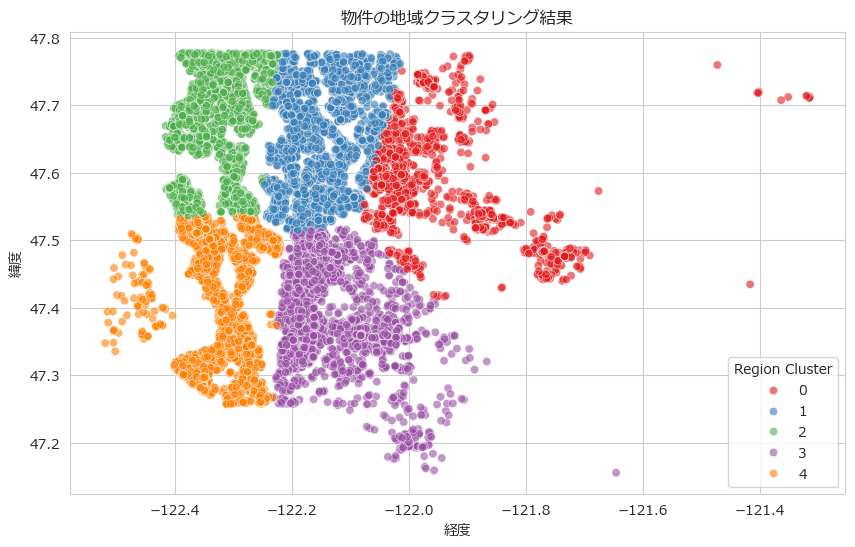

In [21]:
# 6.2 地域別の特徴量の作成

from sklearn.cluster import KMeans

# クラスタリングに使用する緯度と経度の抽出
coordinates = data_filtered[['lat', 'long']]

# クラスタ数の設定（例: 5クラス）
n_clusters = 5

# K-Meansクラスタリングの実行
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data_filtered['region_cluster'] = kmeans.fit_predict(coordinates)

# クラスタリング結果の確認
plt.figure(figsize=(10, 6))
sns.scatterplot(x='long', y='lat', hue='region_cluster', palette='Set1', data=data_filtered, legend='full', alpha=0.6)
plt.title("物件の地域クラスタリング結果")
plt.xlabel("経度")
plt.ylabel("緯度")
plt.legend(title='Region Cluster')
plt.show()


### 6.3 特徴量のエンコーディング

クラスタリングによって作成した `region_cluster` は数値データとしてモデルに取り込むことができますが、カテゴリ変数として扱う場合はワンホットエンコーディングを適用します。以下では、`region_cluster` をダミー変数に変換します。


In [22]:
# 6.3 特徴量のエンコーディング

# ワンホットエンコーディングの適用
data_final = pd.get_dummies(data_filtered, columns=['region_cluster'], prefix='region')

# 確認
display(data_final.head())


,date,price,sqft_lot,sqft_living,grade,lat,long,yr_built,yr_renovated,year_sold,month_sold,days_since_2014_01_01,renovated_flag,years_since_renovation,age,region_0,region_1,region_2,region_3,region_4
0,2014-10-13,221900,5650,1180,7,47.51,-122.26,1955,0,2014,10,286,0,0,59,False,False,False,False,True
1,2014-12-09,538000,7242,2570,7,47.72,-122.32,1951,1991,2014,12,343,1,23,63,False,False,True,False,False
3,2014-12-09,604000,5000,1960,7,47.52,-122.39,1965,0,2014,12,343,0,0,49,False,False,False,False,True
4,2015-02-18,510000,8080,1680,8,47.62,-122.05,1987,0,2015,2,414,0,0,28,True,False,False,False,False
5,2014-05-12,1225000,101930,5420,11,47.66,-122.00,2001,0,2014,5,132,0,0,13,True,False,False,False,False


### 6.4 最終確認

追加した特徴量 `age` とワンホットエンコーディングされた `region_cluster` を含むデータフレームの概要を確認します。


In [23]:
# 6.4 最終確認

# 最終データの確認
display(data_final.head())
display(data_final.info())


,date,price,sqft_lot,sqft_living,grade,lat,long,yr_built,yr_renovated,year_sold,month_sold,days_since_2014_01_01,renovated_flag,years_since_renovation,age,region_0,region_1,region_2,region_3,region_4
0,2014-10-13,221900,5650,1180,7,47.51,-122.26,1955,0,2014,10,286,0,0,59,False,False,False,False,True
1,2014-12-09,538000,7242,2570,7,47.72,-122.32,1951,1991,2014,12,343,1,23,63,False,False,True,False,False
3,2014-12-09,604000,5000,1960,7,47.52,-122.39,1965,0,2014,12,343,0,0,49,False,False,False,False,True
4,2015-02-18,510000,8080,1680,8,47.62,-122.05,1987,0,2015,2,414,0,0,28,True,False,False,False,False
5,2014-05-12,1225000,101930,5420,11,47.66,-122.00,2001,0,2014,5,132,0,0,13,True,False,False,False,False


<class 'pandas.core.frame.DataFrame'>
Index: 16655 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    16655 non-null  datetime64[ns]
 1   price                   16655 non-null  int64         
 2   sqft_lot                16655 non-null  int64         
 3   sqft_living             16655 non-null  int64         
 4   grade                   16655 non-null  int64         
 5   lat                     16655 non-null  float64       
 6   long                    16655 non-null  float64       
 7   yr_built                16655 non-null  int64         
 8   yr_renovated            16655 non-null  int64         
 9   year_sold               16655 non-null  int32         
 10  month_sold              16655 non-null  int32         
 11  days_since_2014_01_01   16655 non-null  int64         
 12  renovated_flag          16655 non-null  int32      

None

## 7. 詳細な探索的データ分析 (EDA)

追加の特徴量エンジニアリングを完了した後、データの詳細な探索的データ分析 (EDA) を実施します。このステップでは、データの傾向やパターン、特徴量間の関係性を深く理解し、予測モデルの構築に向けたインサイトを得ることを目的とします。

以下のサブセクションに分けて分析を行います。

1. **ターゲット変数 (`価格`) の分布確認**
2. **主要特徴量とターゲット変数の関係分析**
3. **相関行列の作成と可視化**
4. **カテゴリ変数の分析**
5. **地域クラスタリングの詳細分析**
6. **特徴量間の関係性の可視化**

---


### 7.1 ターゲット変数 (`価格`) の分布確認

予測対象となる `価格` の分布を確認し、データの偏りや異常値の存在を把握します。価格の分布が偏っている場合、対数変換などの前処理を検討します。


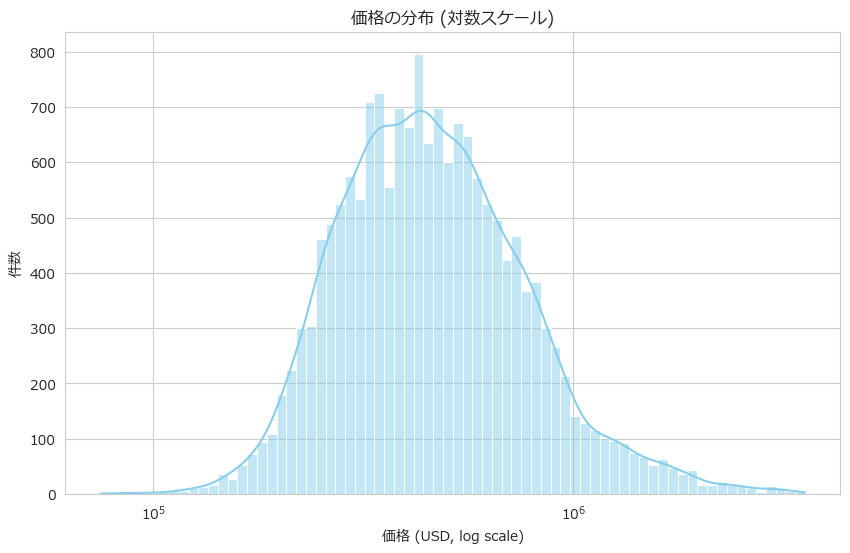

件数         16,655.00
平均        533,860.57
標準偏差      338,064.94
最小         75,000.00
25%       321,000.00
中央値       446,800.00
75%       638,850.00
最大      3,567,000.00
Name: price, dtype: object

In [24]:
# 7.1 ターゲット変数 (`価格`) の分布確認

import matplotlib.pyplot as plt
import seaborn as sns

# 価格のヒストグラム（対数スケール）
plt.figure(figsize=(10, 6))
sns.histplot(data_final['price'], kde=True, color='skyblue', log_scale=True)
plt.title("価格の分布 (対数スケール)")
plt.xlabel("価格 (USD, log scale)")
plt.ylabel("件数")
plt.show()

# 価格の基本統計量
price_stats = data_final['price'].describe()
price_stats = price_stats.rename({
    'count': '件数',
    'mean': '平均',
    'std': '標準偏差',
    'min': '最小',
    '25%': '25%',
    '50%': '中央値',
    '75%': '75%',
    'max': '最大'
})
price_stats = price_stats.apply(lambda x: f"{x:,.2f}")
display(price_stats)


### 7.2 主要特徴量とターゲット変数の関係分析

主要な数値特徴量とターゲット変数 `価格` との関係を可視化し、相関の強さやパターンを確認します。これにより、価格に影響を与える可能性のある重要な特徴量を特定します。


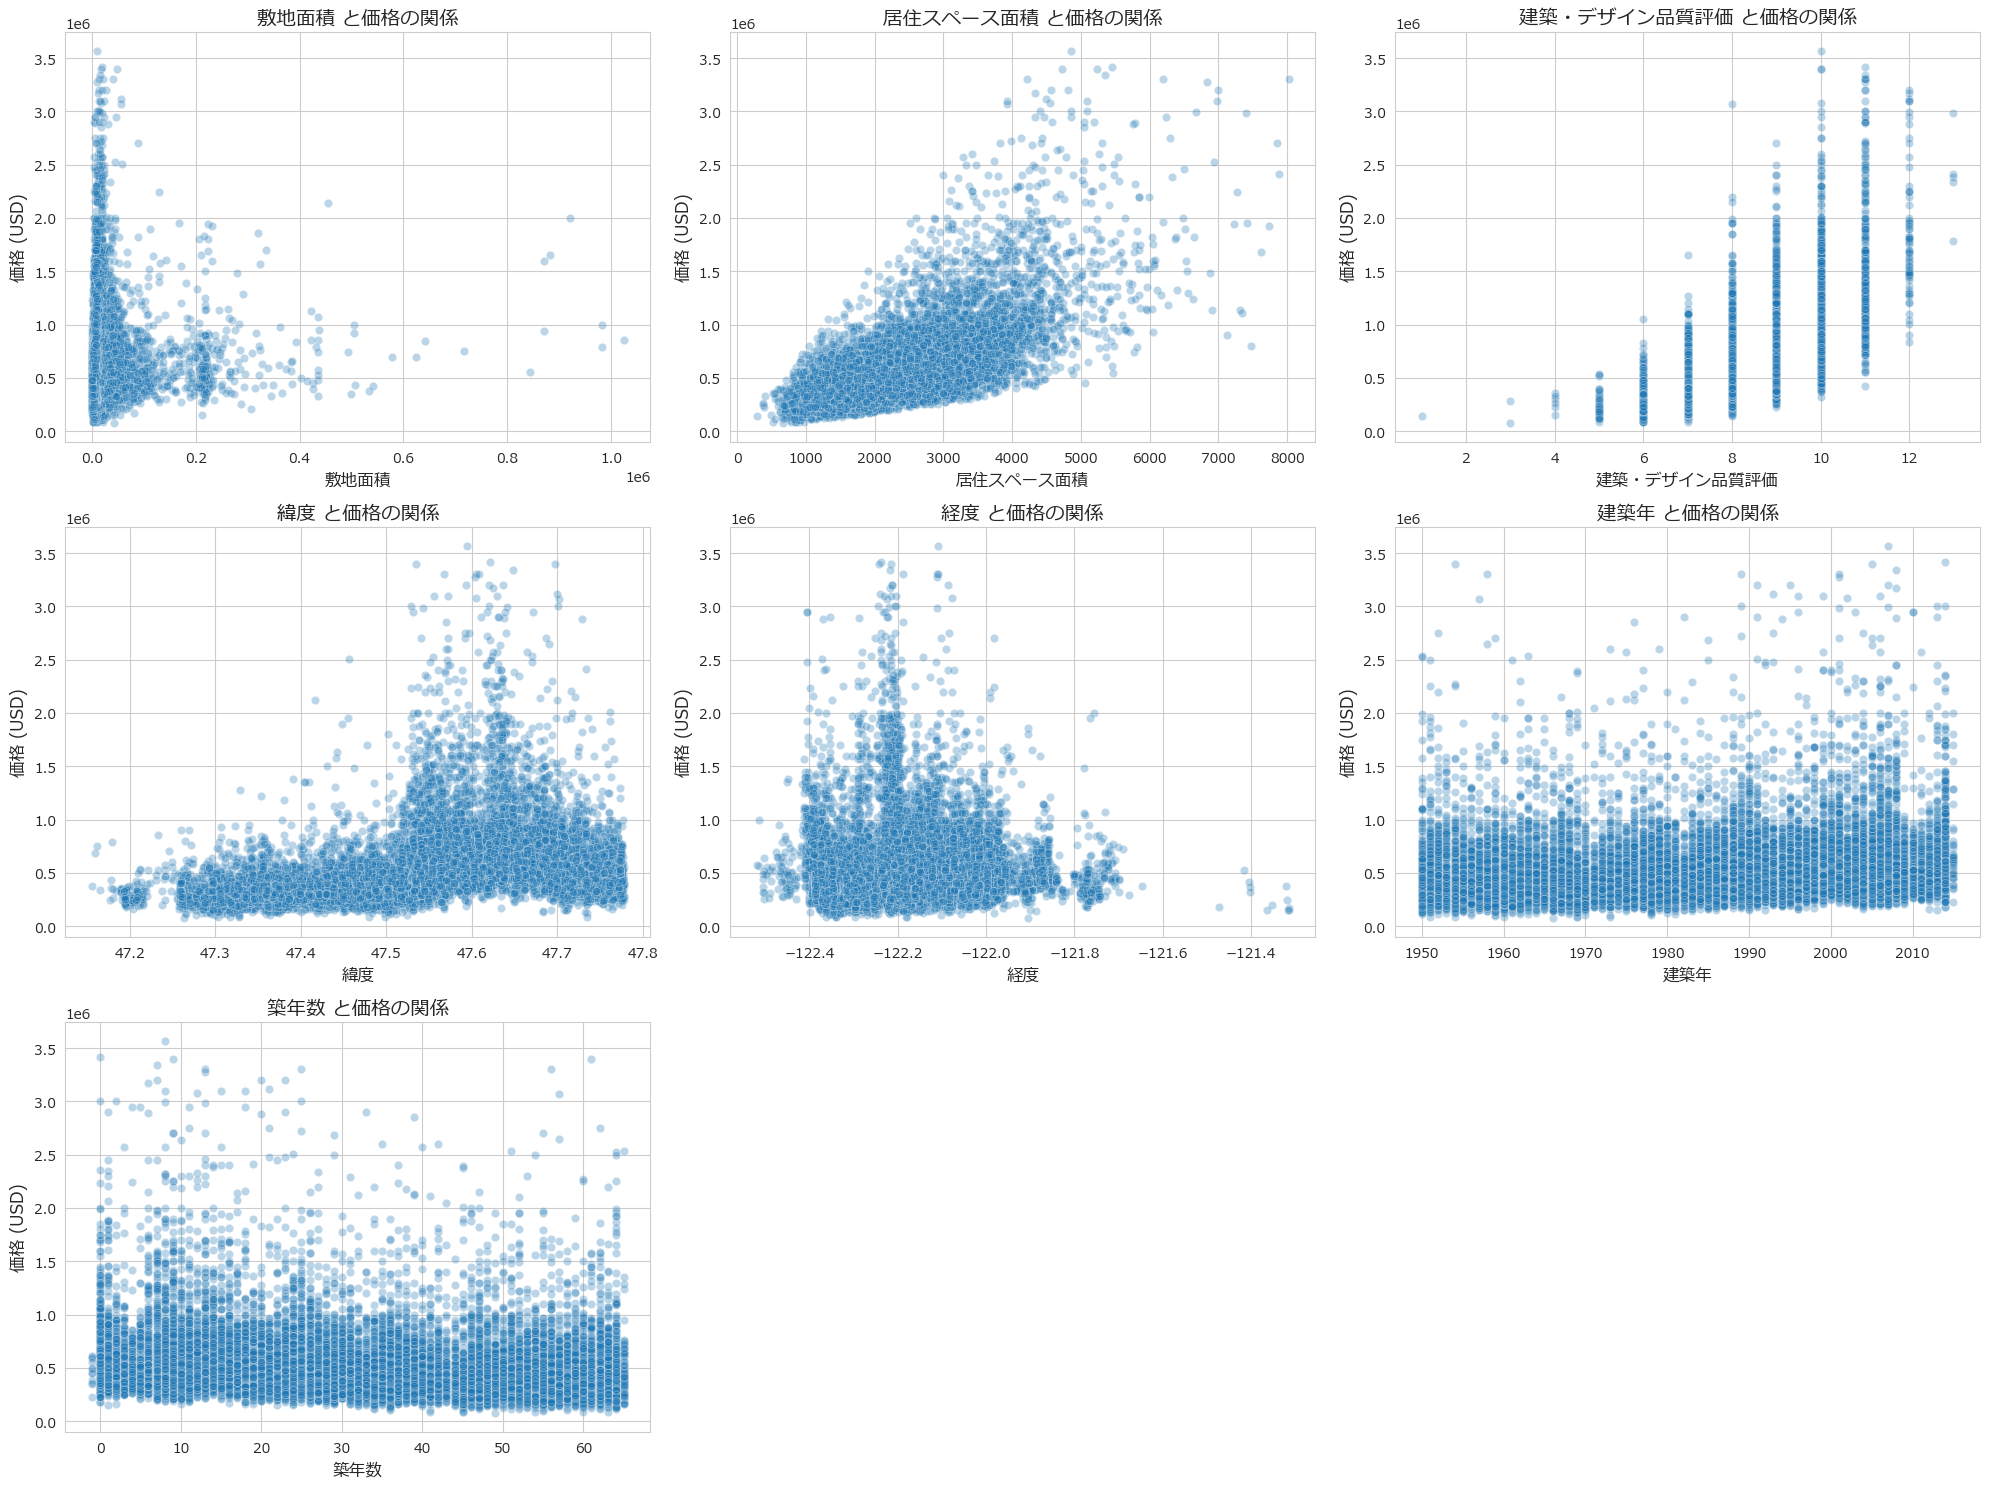

主要特徴量と価格の相関係数 (日本語表示):


,価格との相関係数
建築・デザイン品質評価,0.71
居住スペース面積,0.71
緯度,0.34
建築年,0.17
敷地面積,0.12
経度,0.07
築年数,-0.17


In [38]:
# 7.2 主要特徴量とターゲット変数の関係分析

# 主要数値特徴量のリスト
numeric_features = ['sqft_lot', 'sqft_living', 'grade', 'lat', 'long', 'yr_built', 'age']

# 日本語ラベルの辞書
feature_jp = {
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'age': '築年数'
}

# 散布図を作成し、各特徴量を日本語で表示
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=data_final[feature], y=data_final['price'], alpha=0.3)
    jp_label = feature_jp.get(feature, feature)
    plt.title(f"{jp_label} と価格の関係", fontsize=14)
    plt.xlabel(jp_label, fontsize=12)
    plt.ylabel("価格 (USD)", fontsize=12)
plt.tight_layout()
plt.show()

# 各特徴量と価格の相関係数
correlations = {}
for feature in numeric_features:
    corr = data_final['price'].corr(data_final[feature])
    correlations[feature] = corr

# 相関係数をテーブル形式で表示 (日本語化)
feature_names = {
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'age': '築年数'
}

corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['価格との相関係数'])
corr_df.index = corr_df.index.to_series().apply(lambda x: feature_names.get(x, x))
corr_df = corr_df.sort_values(by='価格との相関係数', ascending=False).round(2)

print("主要特徴量と価格の相関係数 (日本語表示):")
display(corr_df)


### 7.3 相関行列の作成と可視化

数値特徴量間の相関関係を把握するために、相関行列を作成しヒートマップで可視化します。これにより、相関の強いペアや多重共線性の可能性を確認します。


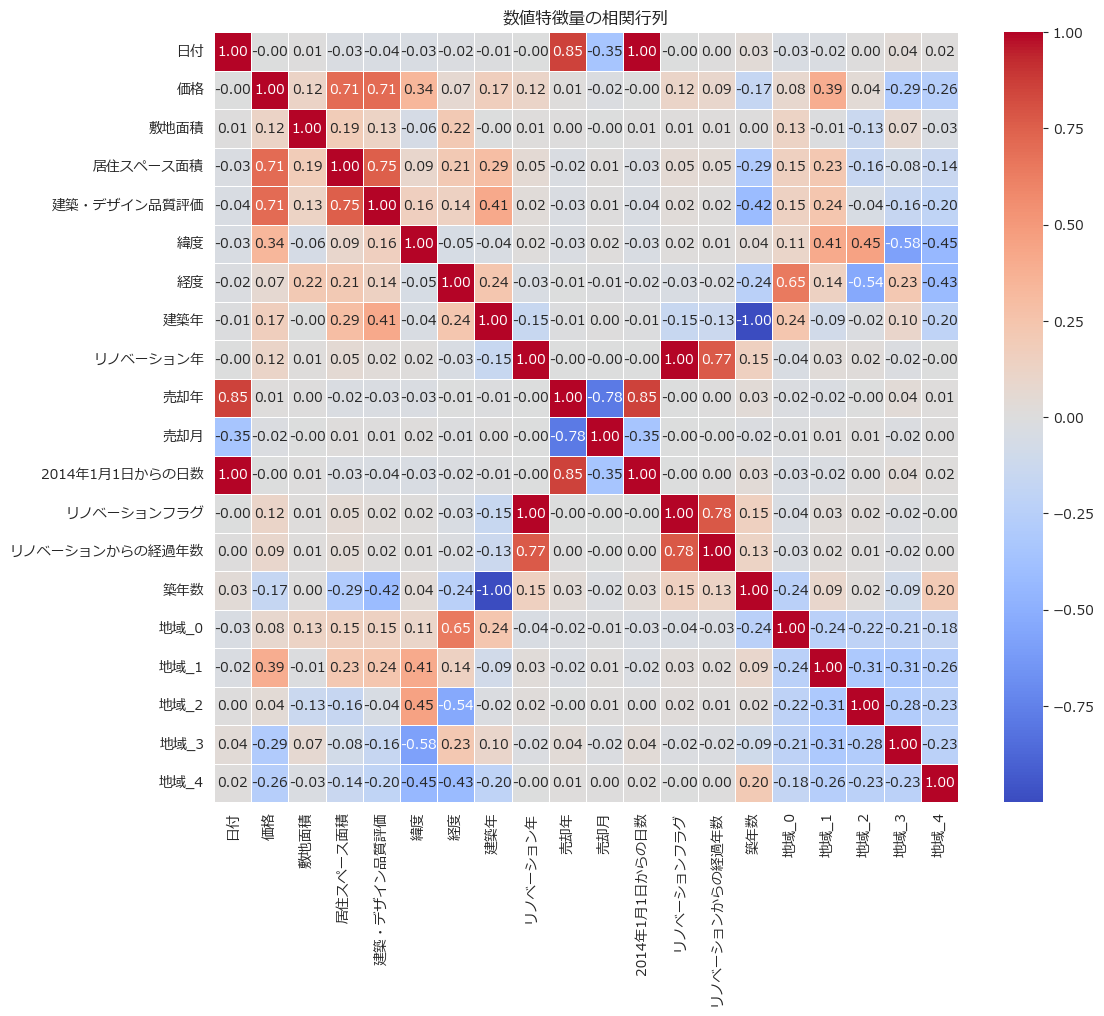

,日付,価格,敷地面積,居住スペース面積,建築・デザイン品質評価,緯度,経度,建築年,リノベーション年,売却年,売却月,2014年1月1日からの日数,リノベーションフラグ,リノベーションからの経過年数,築年数,地域_0,地域_1,地域_2,地域_3,地域_4
日付,1.00,-0.00,0.01,-0.03,-0.04,-0.03,-0.02,-0.01,-0.00,0.85,-0.35,1.00,-0.00,0.00,0.03,-0.03,-0.02,0.00,0.04,0.02
価格,-0.00,1.00,0.12,0.71,0.71,0.34,0.07,0.17,0.12,0.01,-0.02,-0.00,0.12,0.09,-0.17,0.08,0.39,0.04,-0.29,-0.26
敷地面積,0.01,0.12,1.00,0.19,0.13,-0.06,0.22,-0.00,0.01,0.00,-0.00,0.01,0.01,0.01,0.00,0.13,-0.01,-0.13,0.07,-0.03
居住スペース面積,-0.03,0.71,0.19,1.00,0.75,0.09,0.21,0.29,0.05,-0.02,0.01,-0.03,0.05,0.05,-0.29,0.15,0.23,-0.16,-0.08,-0.14
建築・デザイン品質評価,-0.04,0.71,0.13,0.75,1.00,0.16,0.14,0.41,0.02,-0.03,0.01,-0.04,0.02,0.02,-0.42,0.15,0.24,-0.04,-0.16,-0.20
緯度,-0.03,0.34,-0.06,0.09,0.16,1.00,-0.05,-0.04,0.02,-0.03,0.02,-0.03,0.02,0.01,0.04,0.11,0.41,0.45,-0.58,-0.45
経度,-0.02,0.07,0.22,0.21,0.14,-0.05,1.00,0.24,-0.03,-0.01,-0.01,-0.02,-0.03,-0.02,-0.24,0.65,0.14,-0.54,0.23,-0.43
建築年,-0.01,0.17,-0.00,0.29,0.41,-0.04,0.24,1.00,-0.15,-0.01,0.00,-0.01,-0.15,-0.13,-1.00,0.24,-0.09,-0.02,0.10,-0.20
リノベーション年,-0.00,0.12,0.01,0.05,0.02,0.02,-0.03,-0.15,1.00,-0.00,-0.00,-0.00,1.00,0.77,0.15,-0.04,0.03,0.02,-0.02,-0.00
売却年,0.85,0.01,0.00,-0.02,-0.03,-0.03,-0.01,-0.01,-0.00,1.00,-0.78,0.85,-0.00,0.00,0.03,-0.02,-0.02,-0.00,0.04,0.01


In [39]:
# 列名の日本語対応辞書を更新
feature_names_jp = {
    'date': '日付',
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'yr_renovated': 'リノベーション年',
    'year_sold': '売却年',
    'month_sold': '売却月',
    'days_since_2014_01_01': '2014年1月1日からの日数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数',
    'age': '築年数',
    'region_0': '地域_0',
    'region_1': '地域_1',
    'region_2': '地域_2',
    'region_3': '地域_3',
    'region_4': '地域_4'
}

# 相関行列の計算
corr_matrix = data_final.corr()

# 日本語フォントの設定
plt.rcParams['font.family'] = 'meiryo'

# 列名を日本語に変更
corr_matrix = corr_matrix.rename(columns=feature_names_jp).rename(index=feature_names_jp)

# ヒートマップの作成
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("数値特徴量の相関行列")
plt.show()
# 相関行列を表形式で表示（スタイル付き）
display(
    corr_matrix.style
    .background_gradient(cmap='coolwarm', vmin=-1, vmax=1)
    .format("{:.2f}")
)

### 7.4 カテゴリ変数の分析

カテゴリ変数である `region_cluster` に基づいて、価格やその他の数値特徴量の分布を比較します。これにより、異なる地域クラスタ間での価格の違いや特徴の違いを確認します。


C:\Users\rainb\AppData\Local\Temp\ipykernel_12208\3080289421.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_melted['cluster'] = filtered_melted['region'].str.replace('region_', '').astype(int)


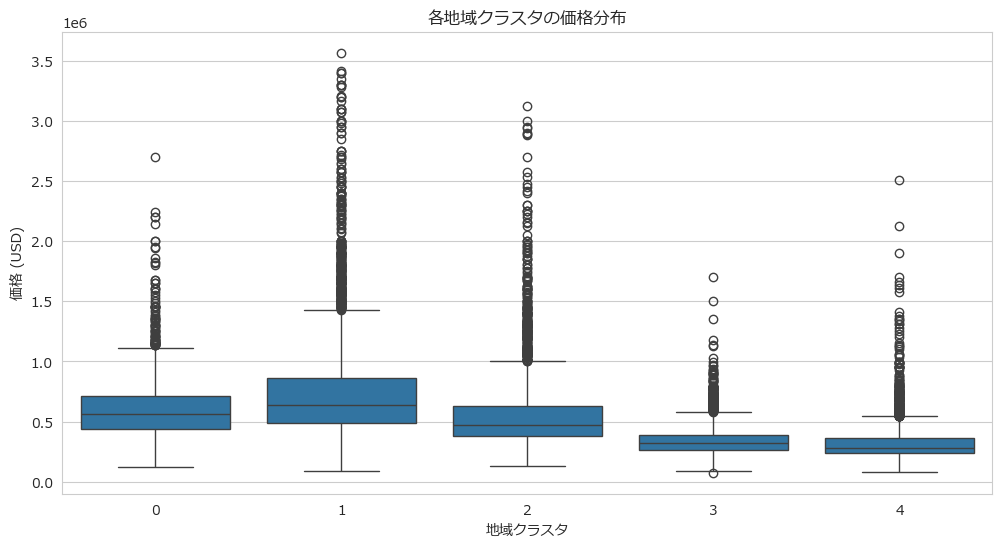

地域クラスタごとの平均価格:


,cluster,price
0,0,"602,879.94"
1,1,"759,018.75"
2,2,"561,450.60"
3,3,"345,794.11"
4,4,"330,659.45"


In [ ]:
# 7.4 カテゴリ変数の分析

# region_cluster のダミー変数名を取得
region_columns = [col for col in data_final.columns if 'region_' in col]

# データを長い形式に変換
melted = pd.melt(data_final, id_vars='price', value_vars=region_columns, var_name='region', value_name='is_region')

# region が True の行のみ抽出
filtered_melted = melted[melted['is_region']]

# クラスタ番号を抽出
filtered_melted['cluster'] = filtered_melted['region'].str.replace('region_', '').astype(int)

# 各地域クラスタごとの価格の分布をボックスプロットで確認
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='price', data=filtered_melted)
plt.title("各地域クラスタの価格分布")
plt.xlabel("地域クラスタ")
plt.ylabel("価格 (USD)")
plt.show()

# 地域クラスタごとの平均価格を計算
region_price_mean = filtered_melted.groupby('cluster')['price'].mean().reset_index()
print("地域クラスタごとの平均価格:")
display(region_price_mean)


### 7.5 地域クラスタリングの詳細分析

地域クラスタリングに基づき、各クラスタの特徴を詳細に分析します。具体的には、各クラスタの平均価格、敷地面積、居住スペース面積などを比較し、地域ごとの特性を把握します。


In [44]:
# 7.5 地域クラスタリングの詳細分析

# クラスタごとの主要特徴量の平均を計算
cluster_features_mean = data_final.groupby('region_').mean()[['price', 'sqft_lot', 'sqft_living', 'age']].reset_index()
cluster_features_mean = cluster_features_mean.rename(columns={
    'region_cluster': '地域クラスタ',
    'price': '平均価格 (USD)',
    'sqft_lot': '平均敷地面積 (平方フィート)',
    'sqft_living': '平均居住スペース面積 (平方フィート)',
    'age': '平均築年数'
})
cluster_features_mean = cluster_features_mean.round({
    '平均価格 (USD)': 2,
    '平均敷地面積 (平方フィート)': 2,
    '平均居住スペース面積 (平方フィート)': 2,
    '平均築年数': 2
})

# クラスタごとの特徴量の表示
print("地域クラスタごとの平均値:")
display(cluster_features_mean)

# クラスタごとの特徴量を棒グラフで可視化
cluster_features_melted = cluster_features_mean.melt(id_vars='地域クラスタ', value_vars=['平均価格 (USD)', '平均敷地面積 (平方フィート)', '平均居住スペース面積 (平方フィート)', '平均築年数'], var_name='特徴量', value_name='平均値')

plt.figure(figsize=(14, 8))
sns.barplot(x='地域クラスタ', y='平均値', hue='特徴量', data=cluster_features_melted)
plt.title("地域クラスタごとの主要特徴量の平均値", fontsize=16)
plt.xlabel("地域クラスタ", fontsize=14)
plt.ylabel("平均値", fontsize=14)
plt.legend(title='特徴量')
plt.show()


KeyError: 'region_'